<a href="https://colab.research.google.com/github/darkwingpatil/Ml_hackethons/blob/main/Hackathon3a_Face_Similarity_and_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

In [1]:
#@title Explanation Video
from IPython.display import HTML

HTML("""<video width="854" height="480" controls>
  <source src="https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/Hackathon3a_face_recognition.mp4" type="video/mp4">
</video>
""")

Face recognition is a method of identifying or verifying the identity of an individual using their face. Face recognition systems can be used to identify people in photos, video, or in real-time. The recent major breakthrough in increasing the face recognition accuracy has come from advancements in Deep Learning and CNNs.

**Objectives:**

**Stage 1:** Build a Siamese Network and obtain the Siamese Representation for the AT&T faces dataset

**Stage 2 (10 Marks):** Use the same Siamese Model to test for Face Similarity on the Mobile App

**Stage 3 (10 Marks):** Get the Siamese Network Representation of the Team Data and build a classifier to perform Face Recognition on the Mobile app


##**Stage 1: Build a Siamese Network**


---


* Define a Siamese network and obtain Siamese Representation on the AT&T Faces Dataset (code given)


**Dataset download**

The [AT&T Faces Dataset](https://git-disl.github.io/GTDLBench/figures/faces.gif) contains 10 different images of each of 40 distinct persons. Images were taken with variations in times, lighting, facial expressions and facial details (eg. glasses / no glasses).

Dataset Statistics: Color: Grayscale; Sample Size: 92x112; Total Samples: 400; Dataset Size: 4.5 MB (compressed in .tar.z)

In [2]:
#@title #####Download the AT&T Dataset.

from IPython import get_ipython
ipython = get_ipython()

notebook="M3_Hackathon" #name of the notebook

def setup():
    ipython.magic("sx wget https://cdn.talentsprint.com/aiml/FaceRecogHackathon/Datasets/ATandT/data-20190607T005435Z-001.zip")
    ipython.magic("sx unzip -qq data-20190607T005435Z-001.zip")

    ipython.magic("sx pip install torch==1.0.1 -f https://download.pytorch.org/whl/cu100/stable")
    ipython.magic("sx pip install torchvision==0.2.1")
    ipython.magic("sx pip install opencv-python")
    ipython.magic("sx pip uninstall -y scikit-learn")
    ipython.magic("sx pip install scikit-learn==0.22.2.post1")
    print ("Setup completed successfully")
    return
setup()

Setup completed successfully


In [ ]:
%ls

In [1]:
!pip install "pillow<7"

#### **Imports: All the imports are defined here**

In [2]:
!pip install -U scikit-learn

In [3]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

**Helper functions**

In [4]:
## The below function plots a given tensor image
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    # In PyTorch, the order of dimension is "channel*width*height" but in matplotlib it is "width*height*channel".
    # So a transpose is performed to correctly index the dimensions
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## We will use the below method to plot the loss graph while training
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

**Configuration class**

In [5]:
# A simple class to manage all configurations
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

**Display a sample image**

(112, 92, 3)


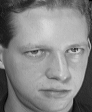

In [6]:
import cv2
from google.colab.patches import cv2_imshow

# Opencv's imread takes full path of an image as input to read an image
im1 = cv2.imread('./data/faces/training/s1/10.pgm')
print(im1.shape)
cv2_imshow(im1)

#### **Define a custom SiameseNetworkDataset class**

This dataset generates a pair of images. 0 for geniune pair (similar) and 1 for imposter pair (dissimilar)

In [7]:
# Below is the class of custom dataset which arranges images in pairs and gives the labels. if both are same, then label will be 0 otherwise 1
# As our images are in .pgm extension (portable gray map) we converting them 'L' to store luminance which is basically single channel image.

class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    # Overriding the data retriever (__getitem__) to provide a pair of images + similar/dissimilar label
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

**Create an Image Folder Dataset**

In [8]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

**Create the Siamese Network Dataset**

In [13]:
# Create the object for the SiameseNetworkDataset class (defined earlier in this notebook);
import collections # Import Iterable from collections.abc

if not hasattr(collections, 'Iterable'):
    collections.Iterable = collections.abc.Iterable

# NOTE: the 'TRANSFORMS' HERE CONSISTS OF
# a) resizing to 100*100
# b) Converting to tensor.

# YOU HAVE TO APPLY THE SAME TRANSORMS WHEN DEPLOYING THE MODEL ON THE SERVER!!

siamese_dataset = SiameseNetworkDataset(imageFolderDataset = folder_dataset, transform = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()]))

**Visualising some of the data**
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:70: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:70: UserWarning: TypedStorage i

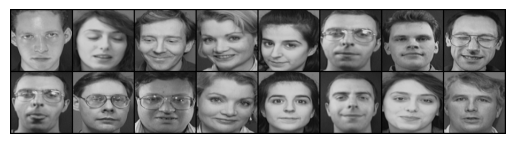

[[1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [14]:
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8)

dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

#### **Neural Net Definition**

We will use a standard convolutional neural network

In [15]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),       #Pads the input tensor using the reflection of the input boundary, it similar to the padding.
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    # forward_once is for one image. This can be used while classifying the face images
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

**Contrastive Loss**

In [16]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

**Training the model**

In [17]:
train_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=Config.train_batch_size)

In [18]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005)

In [19]:
counter = []
loss_history = []
iteration_number= 0

In [20]:
%%capture
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

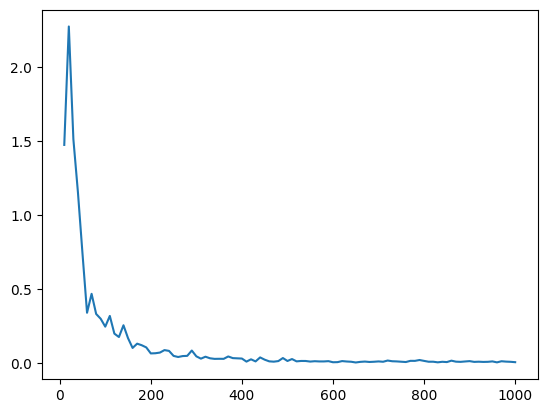

In [21]:
# Plotting the loss graph using the function show_plot
show_plot(counter,loss_history)

**Saving and loading model**

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [22]:
## Saving the model as a state dictionary
state = {'net_dict': net.state_dict()}
torch.save(state, './siamese_model.t7')

**Verifying the saved model with load_state_dict**

In [23]:
myModel = SiameseNetwork().cuda()

In [ ]:
%ls

In [24]:
ckpt = torch.load('./siamese_model.t7')

<ipython-input-24-9b165c1e9bc0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('./siamese_model.t7')


In [25]:
# Save the state dictionary of the Siamese network (use pytorch only), It will be useful in integrating to the mobile app
# A state_dict is simply a Python dictionary object that maps each layer of the network to its parameters (weights)
# As a Python dictionary it can be easily saved, updated, altered and restored, adding a great deal of modularity to PyTorch models

myModel.load_state_dict(ckpt['net_dict'])

<All keys matched successfully>

##### Create the siamese dataset for the `testing_dir` and also the respective data loader. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found the images more similar, while higher values indicate it found them to be dissimilar.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:70: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:70: UserWarning: TypedStorage i

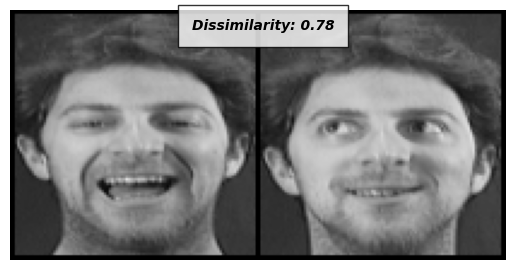

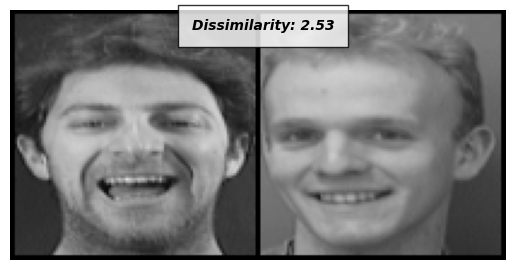

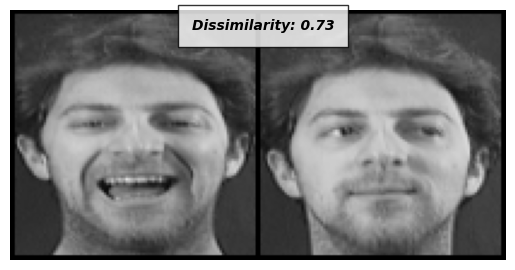

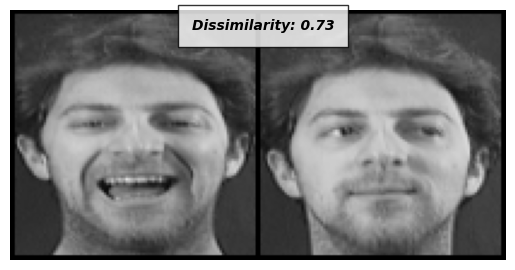

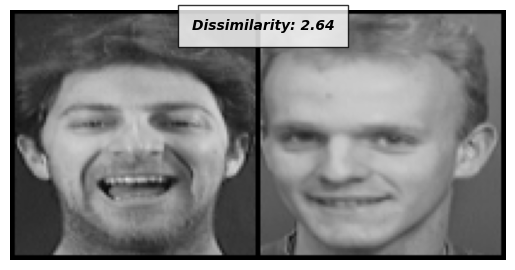

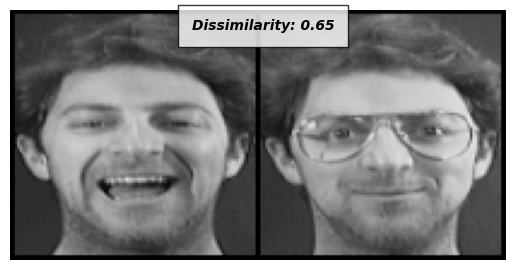

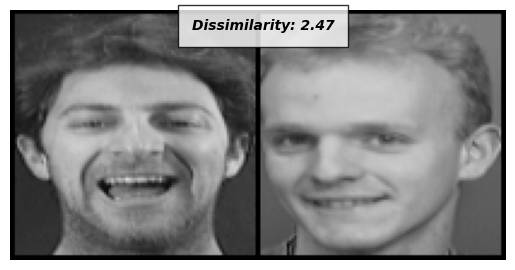

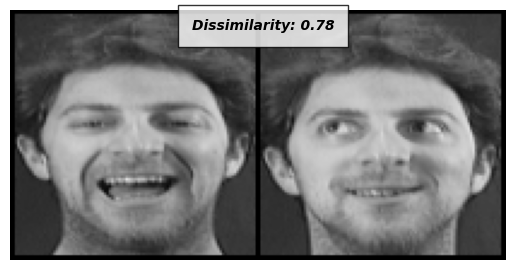

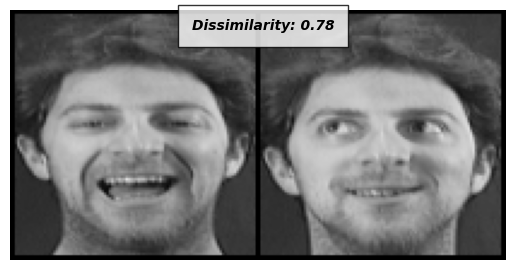

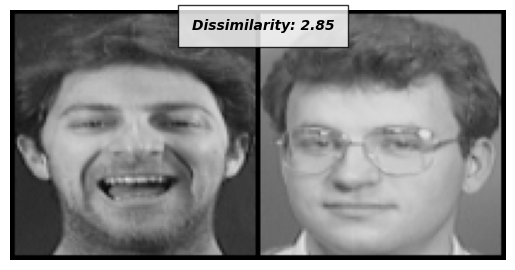

In [27]:
folder_dataset_test = dset.ImageFolder(root = Config.testing_dir) #testing_dir
siamese_dataset = SiameseNetworkDataset(imageFolderDataset = folder_dataset_test,
                                        transform = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()]))

# siamese_dataset = nc.SafeDataset(siamese_dataset)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

# Check the similarity for the first few images from the test data loader
for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)

    output1,output2 = myModel(Variable(x0).cuda(),Variable(x1).cuda()) #using the loaded 'myModel'; even 'net' can be used
    #..but using 'myModel' helps a quick test on if the save and load model is working fine. You will replicate the same
    #..in the server.

    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

##**Stage 2: Test for Face Similarity on Mobile App (10 Marks)**


---




1. Server login and activation steps:

    - A username and password will be provided to your team on the day of the Hackathon.

    - Open the terminal (Command Prompt)
  
  - Login to SSH by typing ssh (username)@aiml-sandbox1.talentsprint.com. Give the login username which is given to you. Type in the password in the next step. Note that the cursor does not move while typing the password.

   `Eg: ssh b16h3gxx@aiml-sandbox1.talentsprint.com`

    (If it is your first time connecting to the server from this computer, accept the connection by typing "yes".)
    - After logging into SSH, activate your virtual environment using the
command **source venv/bin/activate** and then press enter
    - You can start the server by giving the command **sh runserver.sh** and then press enter.

2. Download the Siamese model and upload it in the ftp server (refer to [Filezilla Installation and Configuration document](https://drive.google.com/file/d/19UIKpyVK4r12Dxklo8quQdZQ31PWpiKM/view?usp=drive_link))


3. Update the Siamese model architecture in the **face_recognition_model.py** file and provide the code in the **'get_similarity()'** function of the **face_recognition.py file**. (See Deployment related files)

4. Test the Siamese model in the Mobile app using its Face Similarity application

  - Capture your pic twice and it will return a number between 0 (similar) and 1 (dissimilar) indicating the similarity measure

##**Stage 3: Build Face Recognition Classification Model with Siamese Representation of Team Data and Test on Mobile App (10 Marks)**


---


- Build a Face Recognition Classification Model on Team data
    - Collect Team data on the EFR app (activate the server first)
    
    - Follow the "Mobile_APP_Documentation" to collect the Faces of your team. These will be stored in the server, for which the login is provided to you. [Mobile_APP_Documentation](https://drive.google.com/file/d/1F9SU-BwKViK_eZV2-P3pymvGUILUoVFf/view?usp=drive_link)

    - Train a classifier (use any classifier) with the features extracted from the above trained Siamese network, for your Team Data
    - Save the Classification Model with joblib (if Sklearn classification model is used)

- Deploy on the Server

    - Download the trained models (Siamese model, Classification model) and upload them in the ftp server (refer to [Filezilla Installation and Configuration document](https://drive.google.com/file/d/19UIKpyVK4r12Dxklo8quQdZQ31PWpiKM/view?usp=drive_link))
    - Update the Siamese model architecture in the face_recognition_model.py file (If Required) and the code in the **'get_face_class()'** function of the face_recognition.py file. (See Deployment related files)

- Test the model using the Face Recognition application in the EFR Mobile App


**Download your team data from the EFR app into your colab notebook using the links provided below.**

NOTE: Replace the string "username" with your login username (such as b16h3gxx) in the cell below for face images.

This data will be useful while training the networks.

In [182]:
!wget -nH --recursive --no-parent --reject 'index.*' https://aiml-sandbox.talentsprint.com/expression_detection/b23h4g09/captured_face_images/ --cut-dirs=3  -P ./captured_face_images

--2024-11-16 08:43:32--  https://aiml-sandbox.talentsprint.com/expression_detection/b23h4g09/captured_face_images/
Resolving aiml-sandbox.talentsprint.com (aiml-sandbox.talentsprint.com)... 139.162.203.12
Connecting to aiml-sandbox.talentsprint.com (aiml-sandbox.talentsprint.com)|139.162.203.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘./captured_face_images/index.html.tmp’

index.html.tmp          [ <=>                ]     905  --.-KB/s    in 0s      

2024-11-16 08:43:33 (208 MB/s) - ‘./captured_face_images/index.html.tmp’ saved [905]

Loading robots.txt; please ignore errors.
--2024-11-16 08:43:33--  https://aiml-sandbox.talentsprint.com/robots.txt
Reusing existing connection to aiml-sandbox.talentsprint.com:443.
HTTP request sent, awaiting response... 404 Not Found
2024-11-16 08:43:33 ERROR 404: Not Found.

Removing ./captured_face_images/index.html.tmp since it should be rejected.

--2024-11-16 08:43:33--  https:

In [192]:
# Here simple ImageFolder is enough; we don't need SiameseDataSet
finalClassifierDset = dset.ImageFolder(root='./captured_face_images',
                                       transform = transforms.Compose([transforms.Grayscale(num_output_channels = 1), transforms.Resize((100,100)), transforms.ToTensor()]))

In [197]:
# Dataloader using the dataset created above.

representation_dataloader = DataLoader(finalClassifierDset, shuffle=False, num_workers=8, batch_size=100)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:70: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:70: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:70: UserWarning: TypedStorage is deprecated. It w

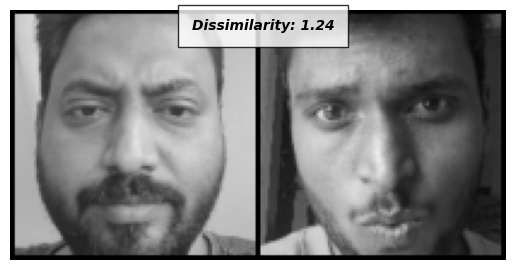

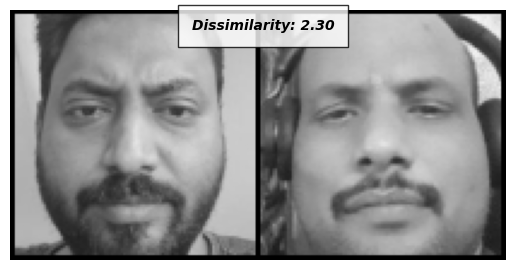

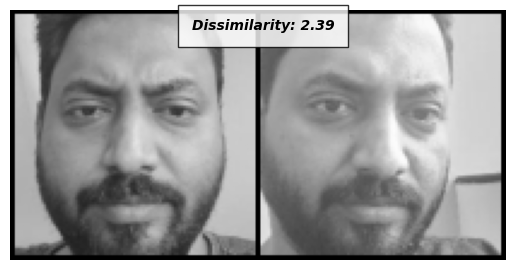

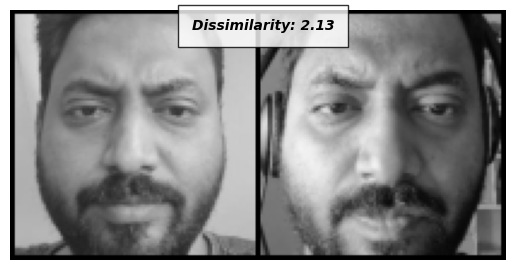

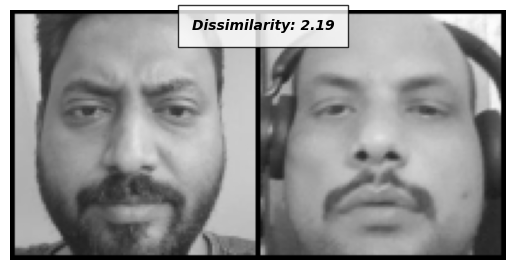

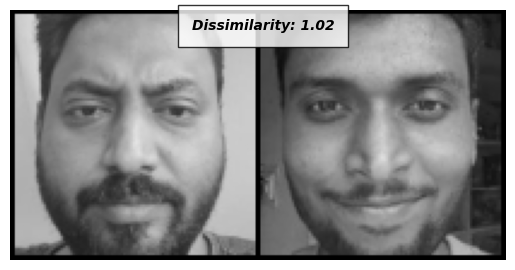

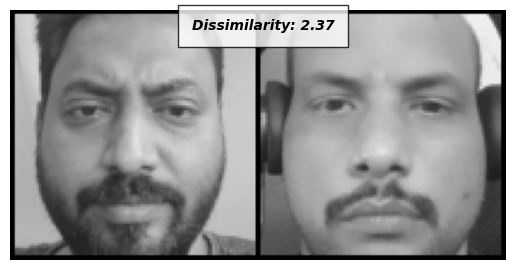

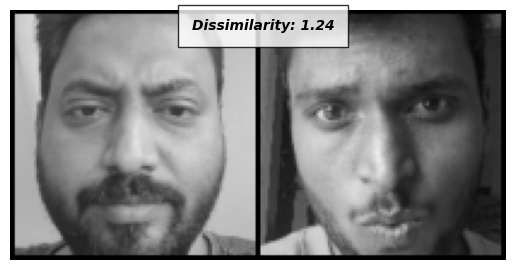

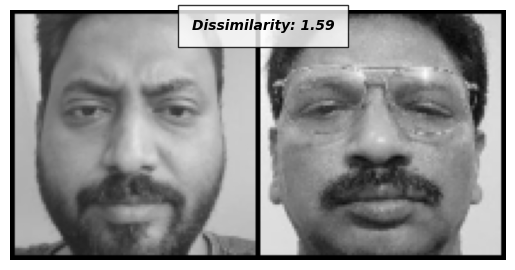

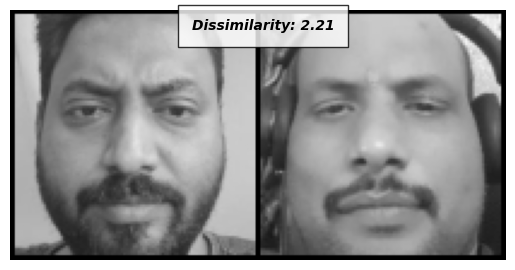

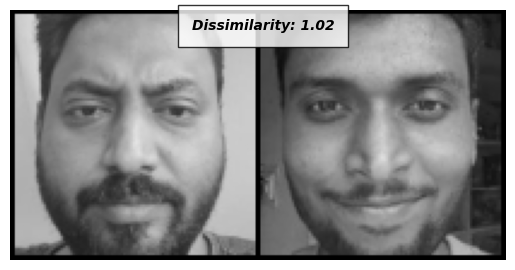

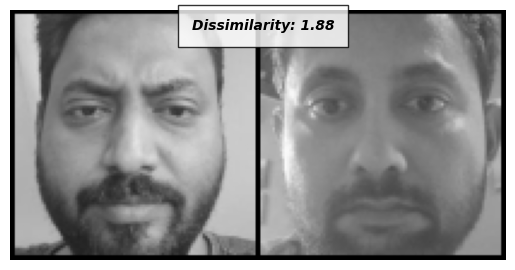

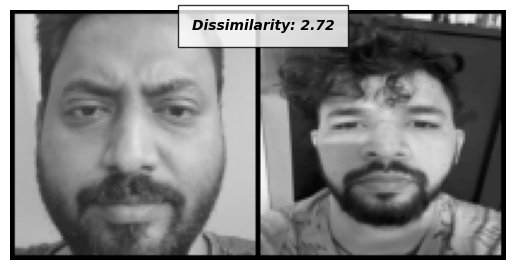

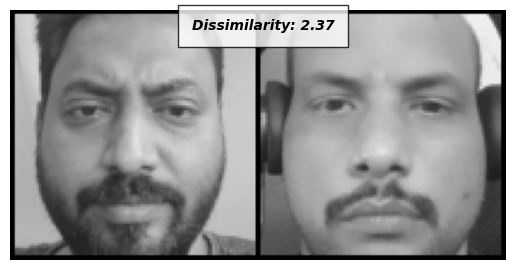

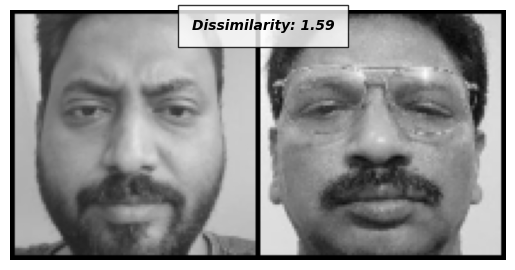

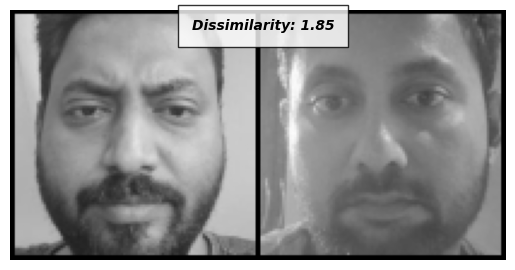

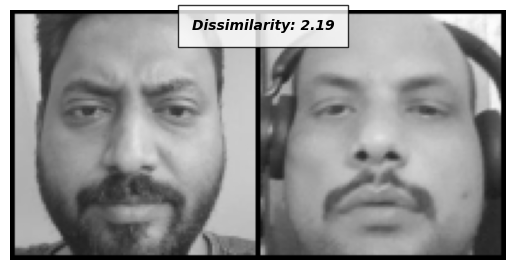

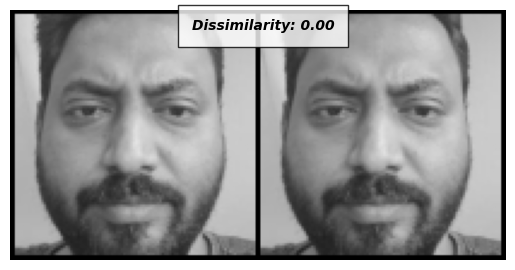

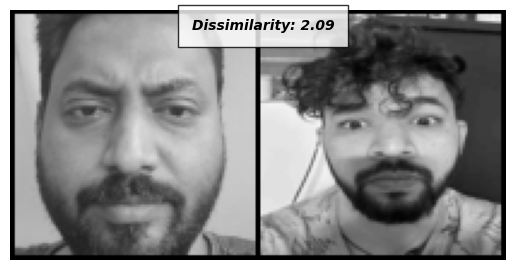

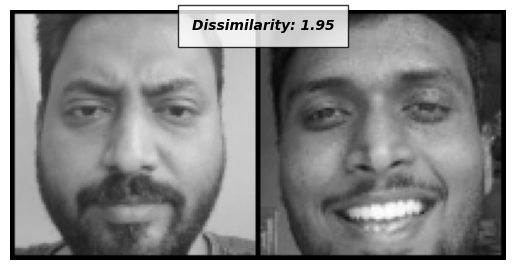

In [44]:
# Load the state dict of the siamese model
# <YOUR CODE HERE>

siamese_dataset_2 = SiameseNetworkDataset(imageFolderDataset = finalClassifierDset,
                                        transform = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()]))

# siamese_dataset = nc.SafeDataset(siamese_dataset)

test_dataloader_2 = DataLoader(siamese_dataset_2,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader_2)
x0,_,_ = next(dataiter)

# Check the similarity for the first few images from the test data loader
for i in range(20):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)

    output1,output2 = myModel(Variable(x0).cuda(),Variable(x1).cuda()) #using the loaded 'myModel'; even 'net' can be used
    #..but using 'myModel' helps a quick test on if the save and load model is working fine. You will replicate the same
    #..in the server.

    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

# for image, lable in representation_dataloader:
#   print(image.shape)

#   print(lable.shape)
#   # Check the similarity for the first few images from the test data loader
#   for i in range(len(image)):
#       x1,label2 = image[0],lable[0]
#       concatenated = torch.cat((x0,x1),0)

#       output1,output2 = myModel(Variable(x0).cuda(),Variable(x1).cuda()) #using the loaded 'myModel'; even 'net' can be used
#       #..but using 'myModel' helps a quick test on if the save and load model is working fine. You will replicate the same
#       #..in the server.

#       euclidean_distance = F.pairwise_distance(output1, output2)
#       imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

In [198]:
emmbbeds=[]
for image, label in representation_dataloader:
  output=myModel.forward_once(image.to(device='cuda'))
  for i in range(len(output)):
      print(output[i].shape)
      print(output[i].cpu().detach().numpy())
      print(output[i].cpu().detach().numpy().reshape(-1))
      print(output[i].device)
      emmbbeds.append({'image':output[i].squeeze(0).cpu().detach().numpy().reshape(-1),'label':label[i].item()})


torch.Size([5])
[-0.6879084  -1.2805207   0.36777347  0.04785278  0.46484363]
[-0.6879084  -1.2805207   0.36777347  0.04785278  0.46484363]
cuda:0
torch.Size([5])
[-0.23431979 -0.79041344  0.33974713  0.31994972  0.56865764]
[-0.23431979 -0.79041344  0.33974713  0.31994972  0.56865764]
cuda:0
torch.Size([5])
[-0.23162936 -0.80545926  0.24479347  0.262993    0.13646348]
[-0.23162936 -0.80545926  0.24479347  0.262993    0.13646348]
cuda:0
torch.Size([5])
[-0.20655178 -0.76453793  0.15854591  0.19046023  0.3437491 ]
[-0.20655178 -0.76453793  0.15854591  0.19046023  0.3437491 ]
cuda:0
torch.Size([5])
[-0.6893301  -1.1550478   0.18956286 -0.07420954  0.41983443]
[-0.6893301  -1.1550478   0.18956286 -0.07420954  0.41983443]
cuda:0
torch.Size([5])
[-0.2134218  -0.63924915 -0.00551307 -0.02365765  0.42402303]
[-0.2134218  -0.63924915 -0.00551307 -0.02365765  0.42402303]
cuda:0
torch.Size([5])
[-1.6124732  -1.7740799  -0.16606563 -0.5239943   0.42212218]
[-1.6124732  -1.7740799  -0.16606563 -0.

In [186]:
df =pd.DataFrame(emmbbeds)

In [127]:
# Get a siamese representation of each of your data points i.e. for each of your team images.
## For example (if your image is of the size 100*100 above)
# <YOUR CODE HERE>
import pandas as pd
faceData=[]
for image, label in representation_dataloader:

  for i in range(len(image)):
    print(image[i].shape)
    print(image[i].device)
    print(output,"putputtt")
    df = faceData.append({'image':image[i].squeeze(0).cpu().numpy().reshape(-1),'label':label[i].item()})
    print(label[i],label[i].item())


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:70: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


torch.Size([1, 100, 100])
cpu


ValueError: expected 4D input (got 3D input)

In [120]:
df =pd.DataFrame(faceData)

In [199]:
df.head()

,image,label
0,"[-0.6879084, -1.2805207, 0.36777347, 0.0478527...",0
1,"[-0.23431979, -0.79041344, 0.33974713, 0.31994...",0
2,"[-0.23162936, -0.80545926, 0.24479347, 0.26299...",0
3,"[-0.20655178, -0.76453793, 0.15854591, 0.19046...",0
4,"[-0.6893301, -1.1550478, 0.18956286, -0.074209...",0


**Train a Classifier for Face Recognition**

You can use any classifier with the features extracted from the above trained Siamese network of your team data. If required, you have to convert torch variable to numpy array before using SkLearn.

In [200]:
# YOUR CODE HERE for training a classifier. You can use simple MLP or Sklearn models.
# Note: Ensure you convert torch variable to numpy array before using SkLearn.

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(df['image'],df['label'],test_size=0.3,random_state=42)



In [201]:
X_train = np.stack(X_train.values)
X_test = np.stack(X_test.values)


In [210]:
X_train.shape

(44, 5)

**Save your classification model**

* Save your sklearn models using joblib



In [202]:
# YOUR CODE HERE for saving the model.
# Note: For SkLearn classifier use joblib for saving the model.
svc = SVC(kernel='rbf', C=1.0, gamma='scale')

svc.fit(X_train,y_train)

y_predict = svc.predict(X_test)

print(accuracy_score(y_test,y_predict))

0.8421052631578947


In [203]:
# Testing passing single image

def process_single_image(image_path):
    """
    Processes a single image and returns it as a flattened NumPy array.

    Args:
        image_path (str): Path to the image file.

    Returns:
        numpy.ndarray: Flattened image data.
    """
    # Load the image
    img = Image.open(image_path)

    # Define the transformations
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((100, 100)),
        transforms.ToTensor()
    ])

    # Apply the transformations
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(1)

    # print(img_tensor.shape)

    output=myModel.forward_once(img_tensor.to(device='cuda'))
    return output[0].squeeze(0).cpu().detach().numpy().reshape(-1)

In [224]:
image_embedd=process_single_image('./captured_face_images/Person3/Person3_1731653065.jpg')

In [225]:
outti=image_embedd.reshape(1, -1)

result=svc.predict(outti)

In [230]:
result

array([2])

In [228]:
import joblib

joblib.dump(svc, 'Dw_svc_model.pkl')

['Dw_svc_model.pkl']

**Download your trained model using the code below**
* Given the path of model file the following code downloads it through the browser

In [229]:
from google.colab import files
files.download('./Dw_svc_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>